<a href="https://colab.research.google.com/github/bielrossi15/generator/blob/master/mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image

%matplotlib inline

In [3]:
BATCH_SIZE = 256
SEED = 100

In [4]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images_reshaped = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images_reshaped = (train_images_reshaped - 127.5) / 127.5
t_dataset = tf.data.Dataset.from_tensor_slices(train_images_reshaped).shuffle(60000).batch(BATCH_SIZE)

# **DISCRIMINATOR**

In [5]:
def discriminator_model(img_shape):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", input_shape=img_shape))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same"))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same"))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    return model

In [6]:
d_model = discriminator_model((28,28,1))

In [7]:
d_optimizer = tf.keras.optimizers.Adam(1e-3)  

In [8]:
def discriminator_loss(r_pred, f_pred):
    r_pred = tf.sigmoid(r_pred) # [0,1]
    f_pred = tf.sigmoid(f_pred) # [0,1]
    r_loss = tf.losses.binary_crossentropy(tf.ones_like(r_pred),r_pred) # r_pred ~ 1
    f_loss = tf.losses.binary_crossentropy(tf.zeros_like(f_pred),f_pred) # f_pred ~ 0
    return r_loss + f_loss

# **GENERATOR**

In [9]:
def generator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(7*7*256, input_shape=(SEED,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((7,7,256)))

    print(model.output_shape)

    model.add(tf.keras.layers.Conv2DTranspose(256,5, strides=1,padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    print(model.output_shape)

    model.add(tf.keras.layers.Conv2DTranspose(128,5,strides=2,padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    print(model.output_shape)

    model.add(tf.keras.layers.Conv2DTranspose(64,5,strides=2,padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    print(model.output_shape)

    model.add(tf.keras.layers.Conv2DTranspose(1,5,padding="same"))

    print(model.output_shape)

    return model

In [10]:
g_model = generator_model()

(None, 7, 7, 256)
(None, 7, 7, 256)
(None, 14, 14, 128)
(None, 28, 28, 64)
(None, 28, 28, 1)


In [11]:
g_optimizer = tf.keras.optimizers.Adam(1e-3)

In [12]:
def generator_loss(f_pred):
    f_pred = tf.sigmoid(f_pred)
    f_loss = tf.losses.binary_crossentropy(tf.ones_like(f_pred),f_pred) # f_pred ~ 1
    return f_loss

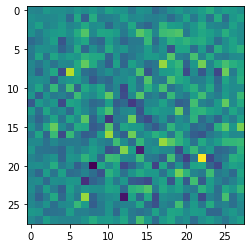

In [16]:
noise = tf.random.normal([1,100])
generated_image = g_model(noise, training=False)
plt.imshow(generated_image[0,:,:,0])

# **TRAINING**

In [20]:
def train(dataset,epochs):
    for _ in range(epochs):
        for images in t_dataset:
            images = tf.cast(images,tf.dtypes.float32)
            train_step(images)

In [21]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,SEED])
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        generated_images = g_model(noise, training=True)
        r_out = d_model(images)
        f_out = d_model(generated_images)

        g_loss = generator_loss(f_out)
        d_loss = discriminator_loss(r_out, f_out)

    gen_gradients = g_tape.gradient(g_loss, g_model.trainable_variables)
    disc_gradients = d_tape.gradient(d_loss, d_model.trainable_variables)

    g_optimizer.apply_gradients(zip(gen_gradients, g_model.trainable_variables))
    d_optimizer.apply_gradients(zip(disc_gradients, d_model.trainable_variables))

    print("generator loss: ", np.mean(g_loss))
    print("discriminator loss: ", np.mean(d_loss))

In [ ]:
train(t_dataset,50)

generator loss:  0.5407514
discriminator loss:  1.3509954
generator loss:  0.6921072
discriminator loss:  1.2324231
generator loss:  0.69289434
discriminator loss:  1.1894212
generator loss:  0.69096196
discriminator loss:  1.1027346
generator loss:  0.5054649
discriminator loss:  1.286588
generator loss:  0.69201696
discriminator loss:  1.0414995
generator loss:  0.69314617
discriminator loss:  1.036997
generator loss:  0.6931468
discriminator loss:  1.0334738
generator loss:  0.6931468
discriminator loss:  1.027028
generator loss:  0.6931468
discriminator loss:  1.0204995
generator loss:  0.6931468
discriminator loss:  1.013625
generator loss:  0.6931468
discriminator loss:  1.0095804
generator loss:  0.6931468
discriminator loss:  1.0081925
generator loss:  0.6931468
discriminator loss:  1.0074763
generator loss:  0.6931468
discriminator loss:  1.0071378
generator loss:  0.6931468
discriminator loss:  1.0069327
generator loss:  0.6931468
discriminator loss:  1.0065324
generator loss

In [ ]:
plt.imshow(tf.reshape(g_model(tf.random.normal([1,100])),(28,28)))